## make a model that predicts conversion

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('conversion_data.csv')

In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
data.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

In [5]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [6]:
data['age'].sort_values(ascending=False)[:10]

90928     123
295581    111
265167     79
192644     77
154217     73
208969     72
114485     70
301366     70
290142     69
57122      69
Name: age, dtype: int64

The above shows that there are a couple exceptionally old people in this group. Maybe entered in error? In any case, I'll remove them because they're spurious for the current purpose.

In [7]:
data = data[data['age'] < 80]

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
print(data.groupby('country')['converted'].mean())

country
China      0.001332
Germany    0.062428
UK         0.052612
US         0.037801
Name: converted, dtype: float64


<Container object of 4 artists>

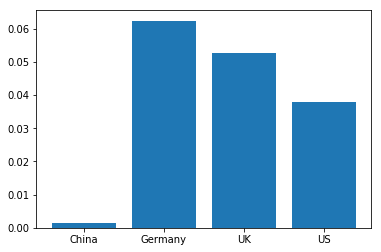

In [10]:
plt.bar(data.groupby('country')['converted'].mean().index, data.groupby('country')['converted'].mean())

In [11]:
from ggplot import *

/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [12]:
cc = data.groupby('country').agg({'converted': 'mean'})
cc

,converted
country,
China,0.001332
Germany,0.062428
UK,0.052612
US,0.037801


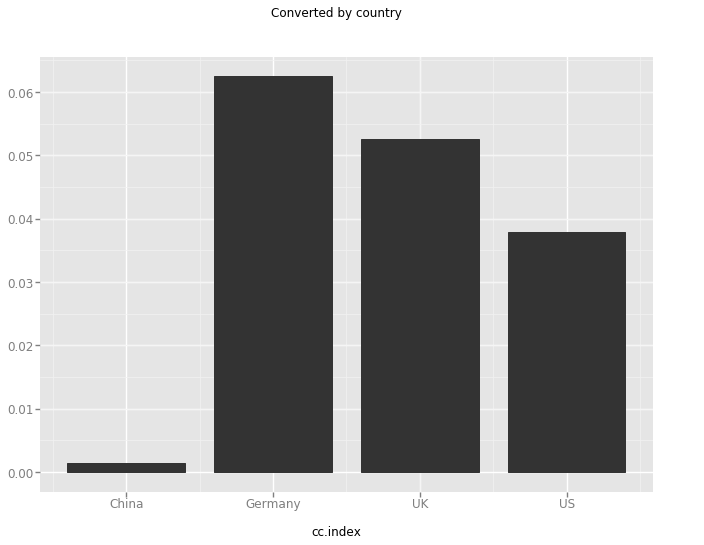

<ggplot: (270648654)>

In [13]:
ggplot(aes(x='cc.index', weight='converted'), cc) + geom_bar() + ggtitle("Converted by country")

In [14]:
df = pd.DataFrame(data.groupby('country')['converted'].mean())

Text(0,0.5,'conversion rate')

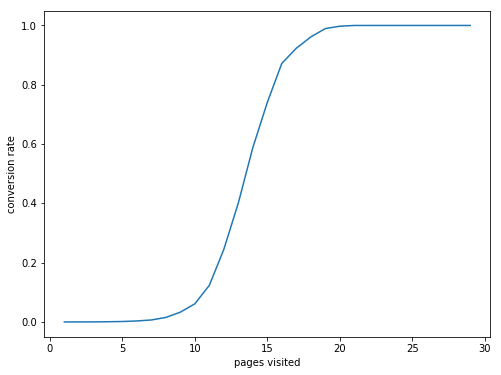

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(data.groupby('total_pages_visited')['converted'].mean())
plt.xlabel('pages visited')
plt.ylabel('conversion rate')

### build a model to predict 

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [17]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [18]:
source_dummies = pd.get_dummies(data.loc[:, 'source'])

In [19]:
data[list(source_dummies.columns)] = source_dummies

In [20]:
data.head()

,country,age,new_user,source,total_pages_visited,converted,Ads,Direct,Seo
0,UK,25,1,Ads,1,0,1,0,0
1,US,23,1,Seo,5,0,0,0,1
2,US,28,1,Seo,4,0,0,0,1
3,China,39,1,Seo,5,0,0,0,1
4,US,30,1,Seo,6,0,0,0,1


In [21]:
country_dummies = pd.get_dummies(data.loc[:, 'country'])
data[list(country_dummies.columns)] = country_dummies

In [22]:
data.head()

,country,age,new_user,source,total_pages_visited,converted,Ads,Direct,Seo,China,Germany,UK,US
0,UK,25,1,Ads,1,0,1,0,0,0,0,1,0
1,US,23,1,Seo,5,0,0,0,1,0,0,0,1
2,US,28,1,Seo,4,0,0,0,1,0,0,0,1
3,China,39,1,Seo,5,0,0,0,1,1,0,0,0
4,US,30,1,Seo,6,0,0,0,1,0,0,0,1


In [23]:
y = data['converted']
X = data.loc[:, ['age', 'new_user', 'total_pages_visited', 'Ads', 'Direct', 'Seo', 'China', 'Germany', 'UK', 'US']]

In [24]:
pd.value_counts(y)

0    306000
1     10198
Name: converted, dtype: int64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [26]:
rf_model = RandomForestClassifier(n_estimators=100, oob_score=True)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [27]:
print('train oob error: {:.3f}%'.format((1-rf_model.oob_score_)*100))

train oob error: 1.572%


In [28]:
from sklearn.metrics import accuracy_score

In [29]:
rf_model_train_prediction = rf_model.predict(X_train)
rf_model_test_prediction = rf_model.predict(X_test)

In [30]:
print('train error: {:.3f}%'.format((1-accuracy_score(y_train, rf_model_train_prediction))*100))
print('test error: {:.3f}%'.format((1-accuracy_score(y_test, rf_model_test_prediction))*100))

train error: 1.137%
test error: 1.578%


**Above test error and training oob error are about the same (1.54% and 1.63%). So it's probably not overfitting. **

In [31]:
pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

total_pages_visited    0.806607
age                    0.115765
new_user               0.036846
China                  0.021916
US                     0.003994
UK                     0.003904
Seo                    0.002833
Ads                    0.002782
Germany                0.002695
Direct                 0.002658
dtype: float64

** Total pages visited is most important. Thinking: this is "least actionable" because people visit a lot of pages as they browse and want to buy, i.e., won't help to get them to buy by having them visit more pages. If anything, it'd probably deter people. **

*** So we'll drop that feature and see what works ***

In [32]:
y = data['converted']
X = data.loc[:, ['age', 'new_user', 'Ads', 'Direct', 'Seo', 'China', 'Germany', 'UK', 'US']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

In [34]:
rf_model = RandomForestClassifier(oob_score=True, n_estimators=100, class_weight={1:0.7, 0:0.3})
rf_model.fit(X_train, y_train)
print('train oob error: {:.3f}%'.format((1-rf_model.oob_score_)*100))

train oob error: 3.274%


*** So the error increases without the total pages visited variable ***

In [35]:
rf_model_train_prediction = rf_model.predict(X_train)
rf_model_test_prediction = rf_model.predict(X_test)

In [36]:
print('train error: {:.3f}%'.format((1-accuracy_score(y_train, rf_model_train_prediction))*100))
print('test error: {:.3f}%'.format((1-accuracy_score(y_test, rf_model_test_prediction))*100))

train error: 3.246%
test error: 3.237%


Very similar error between test and train – probably not overfitting

In [37]:
pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

new_user    0.434348
age         0.309294
China       0.163615
US          0.030663
UK          0.028947
Germany     0.016477
Direct      0.007041
Ads         0.005290
Seo         0.004326
dtype: float64

*** So new user is most important variable now ***

#### Now build a decision tree to characterize 

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
clf = DecisionTreeClassifier(max_depth=3, class_weight={1:0.7, 0:0.3})
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={1: 0.7, 0: 0.3}, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
clf_train_prediction = clf.predict(X_train)
clf_test_prediction = clf.predict(X_test)

In [41]:
print('train error: {:.3f}%'.format((1-accuracy_score(y_train, clf_train_prediction))*100))
print('test error: {:.3f}%'.format((1-accuracy_score(y_test, clf_test_prediction))*100))

train error: 3.233%
test error: 3.210%


In [42]:
pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

new_user    0.473644
China       0.309558
age         0.216798
US          0.000000
UK          0.000000
Germany     0.000000
Seo         0.000000
Direct      0.000000
Ads         0.000000
dtype: float64

In [46]:
print(clf.tree_.children_left)
print(clf.tree_.children_right)
print(len(clf.tree_.children_left))

[ 1  2  3 -1 -1  6 -1 -1  9 10 -1 -1 13 -1 -1]
[ 8  5  4 -1 -1  7 -1 -1 12 11 -1 -1 14 -1 -1]
15


In [92]:
clf.decision_path(X_test).toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 1],
       ..., 
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])